In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
import logging
import os

logger = logging.getLogger(__name__)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "WARNING"))

from common import *
from helpers import *

RK Toolkit 0.0.1b


In [2]:
df = make_df_from_sheet(r"data/GWTC_2021_Master.csv")
df.head(n=1)

,id (Event ID),commonName (Event Name),Classification,version,catalog.shortName,GPS,Mass_1_source (solar masses),mass_1_source_upper_error,Mass_1_Upper Limit (solar masses),mass_1_source_lower_error,...,redshift_upper_limit,far,far_lower,far_upper,p_astro,p_astro_lower,p_astro_upper,final_mass_source,final_mass_source_lower,final_mass_source_upper
0,GW150914-v3,GW150914,Black Hole (High Mass),3,GWTC-1-confident,1126259462,35.6,4.7,40.3,-3.1,...,0.12,1.000000e-07,NaN,NaN,1.0,NaN,NaN,63.1,-3.0,3.4


In [3]:
def preprocess(df):
    ''' Use only numeric columns '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    watched_columns = ["p_astro","SNR_network_matched_filter", "luminosity_distance", "far","chirp_mass_source"]
    for c in watched_columns:
        df = df[df[c].isna() == False]
        df = df.fillna(0)
    df.drop(['far_lower', 'far_upper','p_astro_lower','p_astro_upper'], inplace=True, axis=1)
    subdf = df.select_dtypes(include=numerics)
    invalid_columns = subdf.isna().any()[subdf.isna().any().values== True].index
    subdf = subdf.drop(invalid_columns, axis=1) 
    return subdf

def compute_distance(df):
    mdist = mahalanobis(df, df)
    return (mdist - mdist.min()) / (mdist.max() - mdist.min())

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


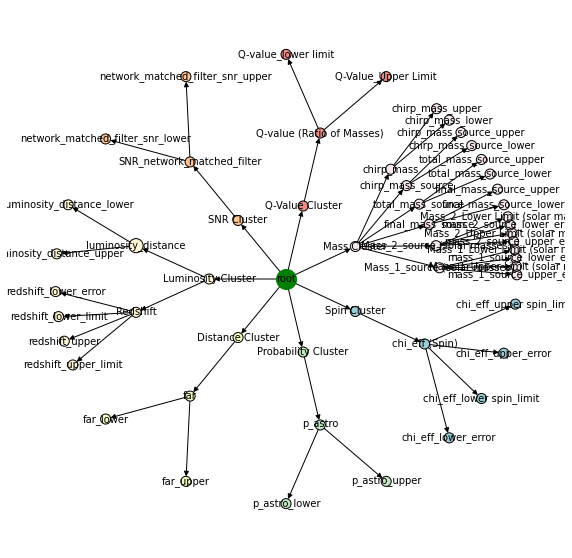

In [4]:
# load the heirarchy file. 
hierarchy_file = r'data/gwtc_heirarchy_pretty.json'
hft = BaseOntologyTransform(mapping=json.load(open(hierarchy_file, "r")))
processed_df = preprocess(df)

# plot the heirarchy
fig, ax = plt.subplots(figsize=(10,10))
g = hft.transform(processed_df.iloc[0])
draw_graph(g , ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False)  
plt.savefig("rendered/heirarchy_graph.png")

In [5]:
opts = {
    "chi_eff (Spin)": [-0.1, 0.1],
    "Q-value (Ratio of Masses)": [.01, .88]
}

def make_linkers_and_filters(graph, opts={}):
    '''
    Defaults all filters to be a range filter. And the linker to be a simple child linker. 
    '''
    ENDL = " | " 
    filters, linkers = {}, {}
    for k, v in graph.nodes.items():
        if 'value' in v and isinstance(v['value'], numbers.Number):
            if v["id"] in opts:
                print("Set {:s} from options".format(v["id"]), end=ENDL)
            else:
                print("Set {:s} to default".format(v["id"]), end=ENDL)
            minv, maxv = opts.get(v["id"][0], 0), opts.get(v["id"][1], 1)
            filters[k] = RangeFilter(min=minv, max=maxv)        
    linkers['root'] = SimpleChildLinker()
    return filters, linkers

filters, linkers = make_linkers_and_filters(g, opts)

Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) from options | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_lower to default | Set luminosit

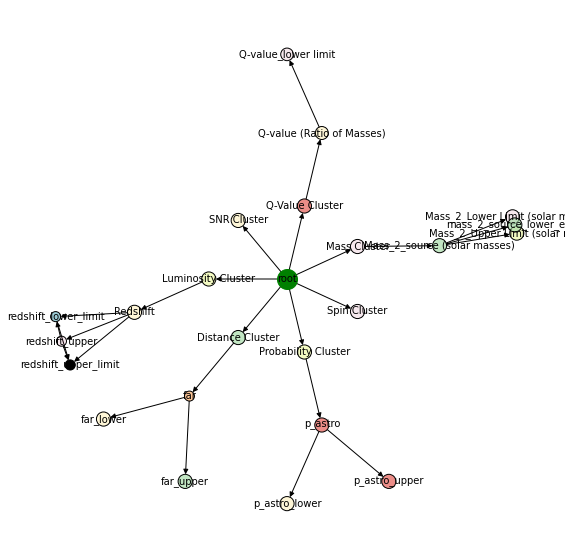

In [6]:
pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
g2 = pipeline.transform(g, is_base=False)
fig, ax = plt.subplots(figsize=(10,10))
draw_rk_diagram(g2, ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False)  
plt.savefig("rendered/rk_graph1.png")

In [7]:
def visualize_n(graphs, n=1, *args, **kwargs):
    fig, ax = plt.subplots(2,int(n/2), figsize=(18,10))
    for i in range(n):
        j, k = i % int(n/2), int(i/(n/2))
        draw_rk_diagram(graphs[i], ax=ax[k][j], *args, **kwargs)
        ax[k][j].set_title(graphs[i].id)

In [8]:
pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)

def make_n_rkmodels(df, labels, n=1, indexes=None):
    rkmodels = []
    
    if indexes is not None:
        for i in indexes:
            base = hft.transform(df.iloc[i])
            rkm = pipeline.transform(base, is_base=False)
            rkm.id = labels.iloc[i]["id (Event ID)"]
            rkmodels.append(rkm)
        return rkmodels
    
    for i, row in df.iterrows():
        if i > n-1:
            break   
        base = hft.transform(df.iloc[i])
        rkm = pipeline.transform(base, is_base=False)
        rkm.id = labels.iloc[i]["id (Event ID)"]
        rkmodels.append(rkm)
    return rkmodels

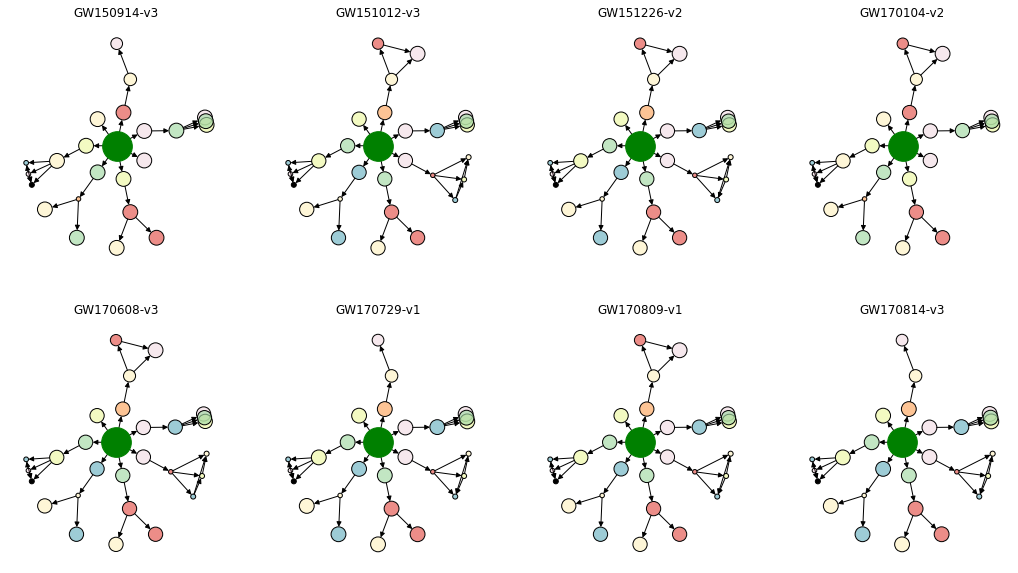

In [9]:
n = 8
rkmodels = make_n_rkmodels(processed_df, df, n=n)
mdist = compute_distance(processed_df)
graphs = [g.get() for g in rkmodels]
#distances = compute_distances(graphs, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
#print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

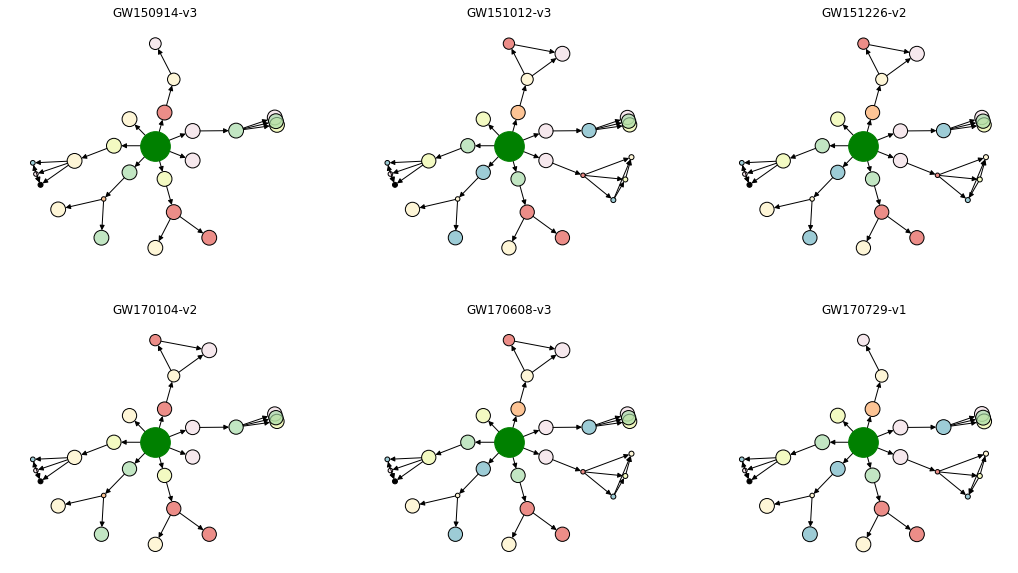

In [10]:
n = 6

rkmodels = make_n_rkmodels(processed_df, df, n=n)
mdist = compute_distance(processed_df)
graphs = [g.get() for g in rkmodels]
#distances = compute_distances(graphs, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
#print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

In [11]:
list(df.columns)

['id (Event ID)',
 'commonName (Event Name)',
 'Classification',
 'version',
 'catalog.shortName',
 'GPS',
 'Mass_1_source (solar masses)',
 'mass_1_source_upper_error',
 'Mass_1_Upper Limit (solar masses)',
 'mass_1_source_lower_error',
 'Mass_1_Lower Limit (solar masses)',
 'Mass_2_source',
 'mass_2_source_upper_error',
 'Mass_2_Upper_Limit (solar masses)',
 'mass_2_source_lower',
 'Mass_2_Lower_Limit (solar masses)',
 'Q-value (Ratio of Masses)',
 'Q-Value_Upper Limit',
 'Q-value_lower limit',
 'SNR_network_matched_filter',
 'network_matched_filter_snr_lower',
 'network_matched_filter_snr_upper',
 'luminosity_distance',
 'luminosity_distance_lower',
 'luminosity_distance_upper',
 'chi_eff (Spin)',
 'chi_eff_lower_error',
 'chi_eff_lower spin_limit',
 'chi_eff_upper_error',
 'chi_eff_upper spin_limit',
 'total_mass_source',
 'total_mass_source_lower',
 'total_mass_source_upper',
 'chirp_mass_source',
 'chirp_mass_source_lower',
 'chirp_mass_source_upper',
 'chirp_mass',
 'chirp_mass_

In [12]:
opts = {
    "chi_eff (Spin)": [-0.1, 0.1],
    "Q-value (Ratio of Masses)": [.01, .88],
    "SNR_network_matched_filter": [100000, -10000],
    "luminosity_distance":[100000,-100000 ],
    "chirp_mass_source": [100000, -10000],
    "far": [100000, -10000],
    "p_astro": [100000, -10000]
}

class FilterAll():
    
    def get_knobs(self):
        pass
    
    def set_knob(self, knb, v):
        pass
    
    def filter(self, node):
        return True
    
def make_linkers_and_filters(graph, opts={}):
    '''
    Defaults all filters to be a range filter. And the linker to be a simple child linker. 
    '''
    ENDL = " | " 
    filters, linkers = {}, {}
    for k, v in graph.nodes.items():
        if 'value' in v and isinstance(v['value'], numbers.Number):
            if v["id"] in opts:
                print("Set {:s} from options".format(v["id"]), end=ENDL)
            #else:
              #  print("Set {:s} to default".format(v["id"]), end=ENDL)
            minv, maxv = 0,1
            if v["id"] in opts:
                minv, maxv = opts[v["id"]][0], opts[v["id"]][1]
            filters[k] = RangeFilter(min=minv, max=maxv) 
    cluster_filters = ["Distance Cluster", "Probability Cluster", "SNR Cluster"]
    for k in cluster_filters:
        filters[k] = FilterAll()
        
    linkers['root'] = SimpleChildLinker()
    return filters, linkers

filters, linkers = make_linkers_and_filters(g, opts)

Set chirp_mass_source from options | Set Q-value (Ratio of Masses) from options | Set SNR_network_matched_filter from options | Set luminosity_distance from options | Set far from options | Set p_astro from options | Set chi_eff (Spin) from options | 

In [13]:
filters["Distance Cluster"].filter(rkmodels[0].get().nodes["Distance Cluster"])

True

In [14]:
rkmodels[0].get().nodes["Distance Cluster"]["value"]

In [15]:
def make_n_rkmodels(df, labels, n=1, indexes=None, pipeline=None):
    rkmodels = []
    
    if indexes is not None:
        for i in indexes:
            base = hft.transform(df.iloc[i])
            rkm = pipeline.transform(base, is_base=False)
            rkm.id = labels.iloc[i]["id (Event ID)"]
            rkmodels.append(rkm)
        return rkmodels
    
    for i, row in df.iterrows():
        if i > n-1:
            break   
        base = hft.transform(df.iloc[i])
        rkm = pipeline.transform(base, is_base=False)
        rkm.id = labels.iloc[i]["id (Event ID)"]
        rkmodels.append(rkm)
    return rkmodels

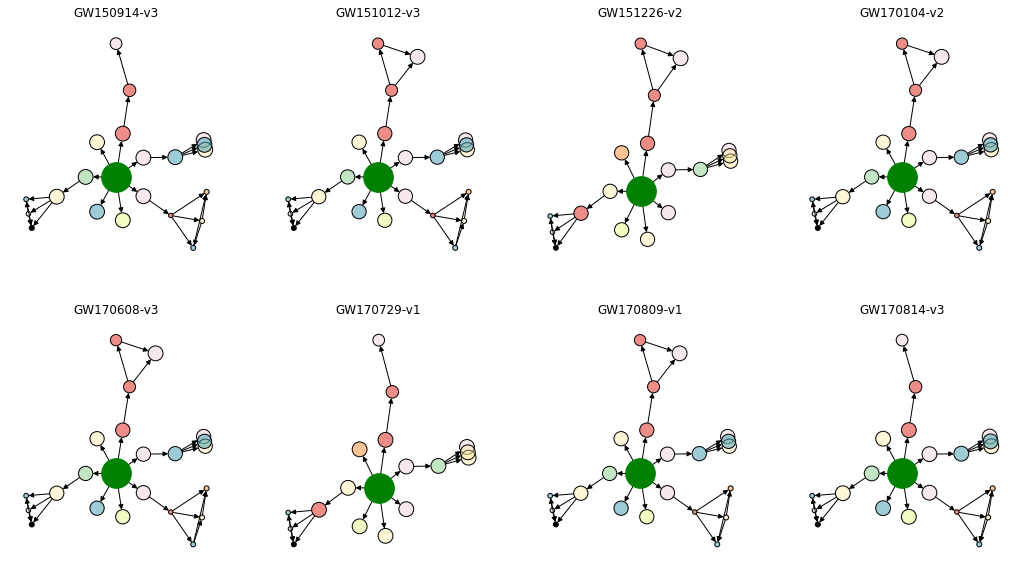

In [16]:
n = 8
pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
rkmodels = make_n_rkmodels(processed_df, df, n=n, pipeline=pipeline)
graphs = [g.get() for g in rkmodels]
#distances = compute_distances(graphs, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
#print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))


In [17]:

selected_events = ["GW170729", "GW170817", "GW190814", "GW190521"]
subset_df = df[df["commonName (Event Name)"].isin(selected_events)]
label_df = df.iloc[subset_df.index]

n = 4
rkmodels = make_n_rkmodels(processed_df, df, n=n, indexes=list(subset_df.index))
mdist = compute_distance(processed_df)
graphs = [g.get() for g in rkmodels]
#distances = compute_distances(graphs, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
#print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

AttributeError: 'NoneType' object has no attribute 'transform'

## Tuning

In [ ]:
import nevergrad as ng
from concurrent import futures
import time

w0 = pipeline.get_w()

class ObjectiveFunction():
    
    def __init__(self, pipeline, sample_size):
        self.pipeline = pipeline
        self.sample_size = sample_size
        
    def evaluate(self, w):
        pupdate = self.pipeline.remap(w, w0[1])
        models = []
        sample = df.sample(n=self.sample_size)
        for i, row in sample.iterrows():
            g = hft.transform(row)
            g = pupdate.transform(g)
            g.id = i
            models.append(g)
                
        mm = [m.get() for m in models]
        for i in range(len(models)):
            mm[i].id = models[i].id
            
        distances = compute_distances(mm, mdist, [1, 0])
        c = 1 - np.mean(distances)
        return c

def train(iterations=2000, batch_size=10):
    loss_history = []
    optimizer = ng.optimizers.NGOpt(parametrization=len(w0[0]), budget=iterations, num_workers=5)
    prev_time = None
    start = time.time()
    ofunc = ObjectiveFunction(pipeline, batch_size)
    for i in range(optimizer.budget):
        x = optimizer.ask()
        loss = ofunc.evaluate(*x.args, **x.kwargs)
        if i % 100 == 0:
            now = time.time()
            if prev_time is not None:
                print("Iteration: {:05d}. Loss: {:.08f}. ITime {:.02f} seconds. Total time: {:.02f}".format(i, loss, now - prev_time, now-start))
            prev_time = now
        loss_history.append(loss)
        optimizer.tell(x, loss)
    
    recommendation = optimizer.provide_recommendation()
    return recommendation.value, loss_history

### Classification